In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
use_cuda = torch.cuda.is_available()                  # Check for CUDA.
device = torch.device("cuda" if use_cuda else "cpu")  # Set which device to use.
device = 'cpu'

## Load the dataset

In [3]:
train_dataset = pd.read_csv('./OccupancyDataset/datatraining.txt')
test_dataset = pd.read_csv('./OccupancyDataset/datatest2.txt')
LOSS = []
batch_size = 100
numClass = 1

In [4]:
test_dataset.isna().sum().any()

False

## Load dataset to dataloader

In [5]:
XX = train_dataset.values[:,1:-1]
XX = (XX-XX.mean())/XX.std()
train_mean = XX.mean()
train_std = XX.std()

X_train = torch.tensor(train_dataset.values[:,1:-1].astype(np.float))
X_train = F.normalize(X_train)
X_train = X_train.type(torch.FloatTensor)

X_test = torch.tensor(test_dataset.values[:,1:-1].astype(np.float))
X_test = F.normalize(X_test)
X_test = X_test.type(torch.FloatTensor)

y_train = torch.tensor(train_dataset.values[:,-1].astype(np.float))
y_train = y_train.type(torch.FloatTensor)

y_test = torch.tensor(test_dataset.values[:,-1].astype(np.float))
y_test    = y_test.type(torch.FloatTensor)

my_dataset = utils.TensorDataset(X_train,y_train) # create your datset

## Create the model

In [6]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [7]:
model = Net(5, 200)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [8]:
model.eval()
y_pred = model(X_test)
y_pred = y_pred.squeeze()
y_pred[y_pred<=0.5]= 0.0
y_pred[y_pred>0.5] = 1.0
before_train = criterion(y_pred, y_test)
print('Test loss before training' , before_train.item())
correct = (y_pred.cpu().detach().numpy() == y_test.cpu().numpy()).sum()
accuracy = 100 * correct / 9752
print("Accuracy of prediction : ",accuracy)

Test loss before training 3.9950759410858154
Accuracy of prediction :  85.5414273995078


In [9]:
def trainModel(model, train_loader, optimizer, criterion, epochs,X_test,y_test,X_train,y_train,forTrain=False):
    model.train()
    train_loss = []
    test_loss = []
    acc = []
    train_acc = []
    for epoch in range(epochs):
        ave_loss = 0.0
    
        for batch_idx,(inputs, target) in enumerate(train_loader,0):
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(inputs)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), target)

            # Backward pass
            loss.backward()
            optimizer.step()
            ave_loss+=loss.item()
        print('Epoch {}: train loss: {}'.format(epoch, ave_loss/len(train_loader)))
        train_loss.append(ave_loss/len(train_loader))
        
        if forTrain:
            _,trn_accuracy = testModel(model,X_train,y_train,epoch,True)
            train_acc.append(trn_accuracy)
            
        tst_loss,accuracy = testModel(model,X_test,y_test,epoch)
        acc.append(accuracy)
        test_loss.append(tst_loss)
        print()
    if forTrain:
        return train_loss,test_loss,acc,train_acc
    else:
        return train_loss,test_loss,acc


In [10]:
def testModel(model,X_test,y_test,epoch,forTrain=False):
    model.eval()
    y_pred = model(X_test)
    y_pred = y_pred.squeeze()
    y_pred[y_pred<=0.5]= 0.0
    y_pred[y_pred>0.5] = 1.0
    after_train = criterion(y_pred, y_test)
    correct = (y_pred.cpu().detach().numpy() == y_test.cpu().numpy()).sum()
    accuracy = 100 * correct / 9752
    if forTrain:
        print("Accuracy of train prediction : ",accuracy)
    else:
        print("Accuracy of Test prediction : ",accuracy)
    return after_train.item(),accuracy

In [11]:
epochs = 30
train_loader = utils.DataLoader(my_dataset,batch_size=X_train.shape[0]) # create your dataloader
loss,_,_ = trainModel(model, train_loader, optimizer, criterion,epochs,X_test,y_test,X_train,y_train)

Epoch 0: train loss: 0.6703649163246155
Accuracy of Test prediction :  78.98892534864643

Epoch 1: train loss: 0.5713211894035339
Accuracy of Test prediction :  78.98892534864643

Epoch 2: train loss: 0.512248694896698
Accuracy of Test prediction :  78.98892534864643

Epoch 3: train loss: 0.48512086272239685
Accuracy of Test prediction :  78.98892534864643

Epoch 4: train loss: 0.4782361686229706
Accuracy of Test prediction :  78.98892534864643

Epoch 5: train loss: 0.4792085587978363
Accuracy of Test prediction :  78.98892534864643

Epoch 6: train loss: 0.4781500995159149
Accuracy of Test prediction :  78.98892534864643

Epoch 7: train loss: 0.47094500064849854
Accuracy of Test prediction :  78.98892534864643

Epoch 8: train loss: 0.4577856659889221
Accuracy of Test prediction :  78.98892534864643

Epoch 9: train loss: 0.44059842824935913
Accuracy of Test prediction :  78.98892534864643

Epoch 10: train loss: 0.4220569431781769
Accuracy of Test prediction :  78.98892534864643

Epoch 1

In [12]:
_,_ = testModel(model,X_test,y_test,epochs)

Accuracy of Test prediction :  94.81132075471699


# 3b

In [13]:
def maxVote(pred):
    m = stats.mode(pred.T)
    return m[0][0]

In [14]:
y_test_random = np.random.randint(0,2,size=(y_test.shape[0],5))
y_test_random = maxVote(y_test_random)
y_test_random = torch.Tensor(y_test_random)

In [15]:
sigmoid = torch.nn.Sigmoid()
baseline = sigmoid(y_test_random)

In [16]:
# baseline_train = criterion(y_test_random, y_test) 
# print('baseline loss : ' , baseline_train.item())
correct = (y_test_random.cpu().detach().numpy() == y_test.cpu().numpy()).sum()
accuracy = 100 * correct / 9752
print("Accuracy of prediction : ",accuracy)
baseline_loss = 1-accuracy/100#criterion(baseline,y_test).item()
print("Baseline Loss : ",baseline_loss)

Accuracy of prediction :  49.518047579983595
Baseline Loss :  0.5048195242001641


# 3c

In [17]:
train_loader = utils.DataLoader(my_dataset,batch_size=100) # create your dataloader
lr_schedule = [0.1,0.2,0.01,0.02]

loss_schedule = []
training_accuracy_for_lr = []
testing_accuracy_for_lr = []

epochs = 100

for lr in lr_schedule:
    print("\n\nfor lr ",lr)
    model = Net(X_train.shape[1],5)
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    
    train_loader = utils.DataLoader(my_dataset,batch_size=X_train.shape[0]) # create your dataloader

    loss,_,test_acc,train_acc = trainModel(model, train_loader, optimizer, criterion,epochs,X_test,y_test,X_train,y_train,True)
    
    testing_accuracy_for_lr.append(test_acc)
    training_accuracy_for_lr.append(train_acc)
    
    #_,acc = testModel(model,X_test,y_test,epochs)
    
    loss_schedule.append(loss)
    print()



for lr  0.1
Epoch 0: train loss: 0.7810741662979126
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353567

Epoch 1: train loss: 0.7554799914360046
Accuracy of train prediction :  17.719442165709598
Accuracy of Test prediction :  15.771123872026251

Epoch 2: train loss: 0.7325757145881653
Accuracy of train prediction :  7.516406890894175
Accuracy of Test prediction :  6.121821164889253

Epoch 3: train loss: 0.7119891047477722
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  77.46103363412634

Epoch 4: train loss: 0.693428099155426
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 5: train loss: 0.6766437888145447
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 6: train loss: 0.6614552140235901
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoc

Accuracy of Test prediction :  78.98892534864643

Epoch 60: train loss: 0.508327066898346
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 61: train loss: 0.5080022811889648
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 62: train loss: 0.5076823830604553
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 63: train loss: 0.5073556303977966
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 64: train loss: 0.507042646408081
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 65: train loss: 0.5067226886749268
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 66: train loss: 0.506405770778656
Accuracy of train prediction :  65.77112387202625
Accuracy of Test

Epoch 19: train loss: 0.5275325179100037
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 20: train loss: 0.5251957178115845
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 21: train loss: 0.5229241251945496
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 22: train loss: 0.5209161639213562
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 23: train loss: 0.5190163850784302
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 24: train loss: 0.5172277092933655
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 25: train loss: 0.5156491994857788
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 26: tra

Epoch 79: train loss: 0.46065282821655273
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 80: train loss: 0.45933955907821655
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 81: train loss: 0.4579971134662628
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 82: train loss: 0.45666277408599854
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 83: train loss: 0.45528295636177063
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 84: train loss: 0.45389029383659363
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 85: train loss: 0.45248380303382874
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 8

Epoch 39: train loss: 0.6388378739356995
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 40: train loss: 0.637779712677002
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 41: train loss: 0.6367292404174805
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 42: train loss: 0.6356878280639648
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 43: train loss: 0.6346579194068909
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 44: train loss: 0.633638858795166
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 45: train loss: 0.632625162601471
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 46: train 

Epoch 98: train loss: 0.590078592300415
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 99: train loss: 0.589432954788208
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643




for lr  0.02
Epoch 0: train loss: 0.7073314785957336
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353567

Epoch 1: train loss: 0.7054579257965088
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353567

Epoch 2: train loss: 0.7036505937576294
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353567

Epoch 3: train loss: 0.7017818093299866
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353567

Epoch 4: train loss: 0.7000080943107605
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353567


Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 58: train loss: 0.6250371336936951
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 59: train loss: 0.6240001916885376
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 60: train loss: 0.6229651570320129
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 61: train loss: 0.6219428181648254
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 62: train loss: 0.6208879947662354
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 63: train loss: 0.6198810935020447
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 64: train loss: 0.6188870072364807
Accuracy of t

## Plotting Graph of Baseline error and H=5 hidden units, and mini-batches of size N=100

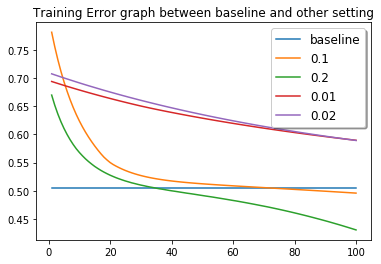

In [18]:
epochs_range = np.arange(1,epochs+1)
baseline = np.ones(epochs)*baseline_loss#random.randint(0,1000,size=(100))
# other = np.random.randint(0,1000,size=(100))
# baseline = np.sort(baseline)
# other = np.sort(other)


plt.plot(epochs_range,baseline,label="baseline")
for i in range(len(loss_schedule)):
    name = str(lr_schedule[i])
    plt.plot(epochs_range,loss_schedule[i],label=name)
plt.legend(loc='best', shadow=True, fontsize='large')
plt.title('Training Error graph between baseline and other setting')
plt.show()

##  training and test set performance in terms of % examples classified correctly.


0


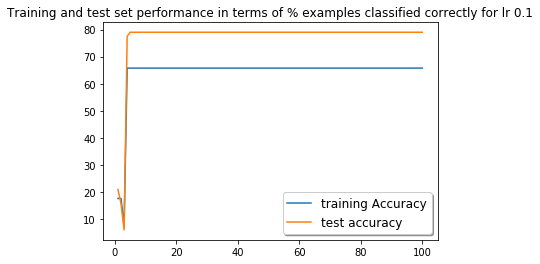

1


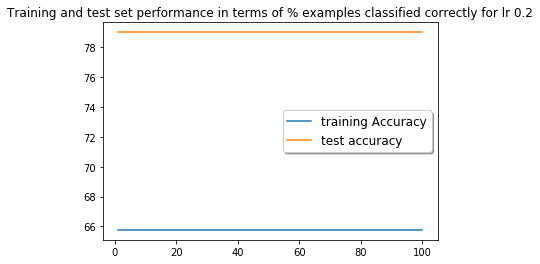

2


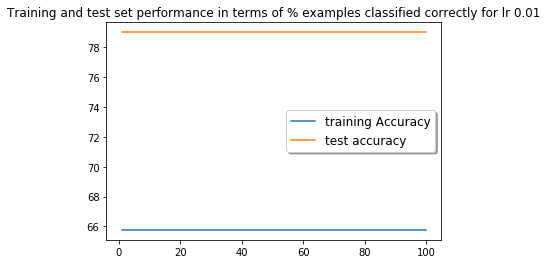

3


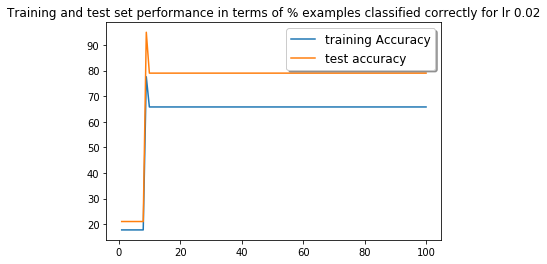

In [19]:
epochs_range = np.arange(1,epochs+1)
for i in range(len(loss_schedule)):
    print(i)
    name = str(lr_schedule[i])
    plt.plot(epochs_range,training_accuracy_for_lr[i],label="training Accuracy")
    plt.plot(epochs_range,testing_accuracy_for_lr[i],label="test accuracy")
    plt.legend(loc='best', shadow=True, fontsize='large')
    title = 'Training and test set performance in terms of % examples classified correctly for lr ' + name
    plt.title(title)
    plt.show()

### Report the learning rate (or learning rate schedule) you used to produce the plot.
I have used lr_schedul = [0.1,0.2,0.01,0.02].

We can see the performance of the setting on the above graphs.

### Report training and test set performance in terms of % examples classified correctly.
We can see the performace of test and train performance for learning rate 0.1 we get max accuracy 81.01927809680066%  after that it drop and remain constant accuracy and constant 65.77112387202625 training

For lr 0.2 - 85.90032813781788 after that it drop and then remains constant.
             65.77112387202625 training constant accuracy
             
for lr 0.01 - 78.98892534864643 constant testing accuracy
              constant as above  
              
For lr 0.02 - starts from 85.84905660377359 and then constant.78.98892534864643 for testing.
              starts from 78.98892534864643 and the constat as above


# 3d

### With batch Size 1

In [20]:
model = Net(X_train.shape[1], 200)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 20
train_loader = utils.DataLoader(my_dataset,batch_size=1) # create your dataloader

loss_SGD,_,accuracy = trainModel(model, train_loader, optimizer, criterion,epochs,X_test,y_test,X_train,y_train)

/home/cs18mtech11033/venv/lib/python3.5/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 0: train loss: 0.028023477745599313
Accuracy of Test prediction :  94.96513535684987

Epoch 1: train loss: 0.027542874546692266
Accuracy of Test prediction :  94.53445447087776

Epoch 2: train loss: 0.031214930855859874
Accuracy of Test prediction :  94.52420016406892

Epoch 3: train loss: 0.03205404686285638
Accuracy of Test prediction :  95.06767842493848

Epoch 4: train loss: 0.0318953144189054
Accuracy of Test prediction :  94.9343724364233

Epoch 5: train loss: 0.030906493479085622
Accuracy of Test prediction :  94.6780147662018

Epoch 6: train loss: 0.030862375377693676
Accuracy of Test prediction :  94.45242001640689

Epoch 7: train loss: 0.030130109000278002
Accuracy of Test prediction :  94.27809680065627

Epoch 8: train loss: 0.0295380767986628
Accuracy of Test prediction :  94.12428219852337

Epoch 9: train loss: 0.02966067129209398
Accuracy of Test prediction :  94.02173913043478

Epoch 10: train loss: 0.029533636868785233
Accuracy of Test prediction :  93.94995898277

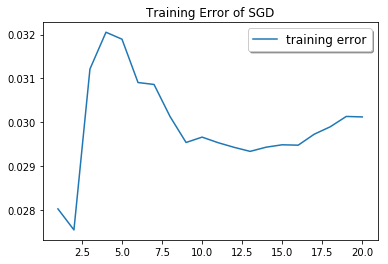

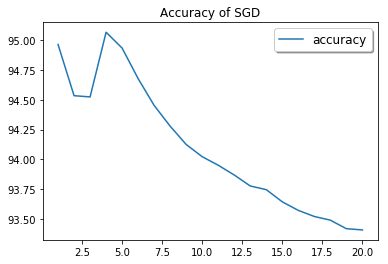

In [21]:
epochs_range = np.arange(1,epochs+1)
plt.plot(epochs_range,loss_SGD,label="training error")

# plt.plot(epochs_range,,label=name)
plt.legend(loc='best', shadow=True, fontsize='large')
plt.title('Training Error of SGD')
plt.show()

plt.plot(epochs_range,accuracy,label="accuracy")

plt.legend(loc='best', shadow=True, fontsize='large')
plt.title('Accuracy of SGD')
plt.show()

### WIth batch size 100

In [22]:
model = Net(X_train.shape[1], 200)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 20
train_loader = utils.DataLoader(my_dataset,batch_size=100) # create your dataloader

loss_SGD,_,accuracy = trainModel(model, train_loader, optimizer, criterion,epochs,X_test,y_test,X_train,y_train)
#_,acc = testModel(model,X_test,y_test,epochs)

Epoch 0: train loss: 0.40243686070075124
Accuracy of Test prediction :  85.64397046759639

Epoch 1: train loss: 0.2950163986761032
Accuracy of Test prediction :  93.87817883511075

Epoch 2: train loss: 0.23654776323791138
Accuracy of Test prediction :  94.41140278917145

Epoch 3: train loss: 0.21268758678911026
Accuracy of Test prediction :  94.45242001640689

Epoch 4: train loss: 0.20272575625326347
Accuracy of Test prediction :  94.77030352748154

Epoch 5: train loss: 0.19721824722790454
Accuracy of Test prediction :  94.96513535684987

Epoch 6: train loss: 0.19442851786507384
Accuracy of Test prediction :  94.94462674323216

Epoch 7: train loss: 0.19283161340309762
Accuracy of Test prediction :  94.85233798195242

Epoch 8: train loss: 0.19105578723176178
Accuracy of Test prediction :  94.87284659557014

Epoch 9: train loss: 0.18854903703464604
Accuracy of Test prediction :  94.92411812961444

Epoch 10: train loss: 0.18676635184149235
Accuracy of Test prediction :  94.883100902379

E

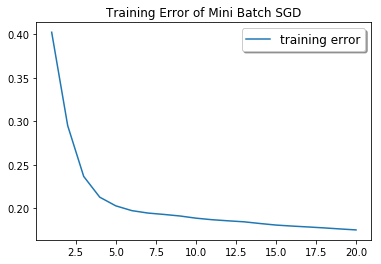

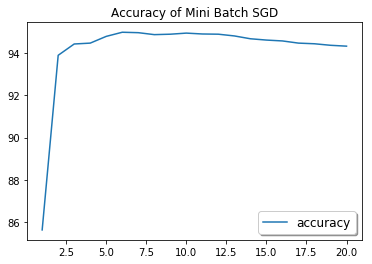

In [23]:
epochs_range = np.arange(1,epochs+1)
plt.plot(epochs_range,loss_SGD,label="training error")

# plt.plot(epochs_range,,label=name)
plt.legend(loc='best', shadow=True, fontsize='large')
plt.title('Training Error of Mini Batch SGD')
plt.show()

plt.plot(epochs_range,accuracy,label="accuracy")

plt.legend(loc='best', shadow=True, fontsize='large')
plt.title('Accuracy of Mini Batch SGD')
plt.show()

### What happens if you use batch gradient descent instead of SGD?
Batch Gradient Descent is faster than SGD as in SGD we are taking every datapoint one by one and calculate loss and update the weight but for batch Gradinet descent we are calculating loss for the size of batch and update the weight. Computationally very very efficient.


### Report your observations
In batch GD we can se that errror came down drastically after 3 epoch then it started decreasing slowly while accuracy one time rises to peak then came down a little probably due to more training.

# 3 e

In [24]:
H = [1, 2, 5, 10, 20]
training_loss = []
testing_loss = []
accuracy = []
epochs = 100
for h in H:
    print("For H ",h)
    model = Net(X_train.shape[1],h)
    model = model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    train_loader = utils.DataLoader(my_dataset,batch_size=100) # create your dataloader
    train_loss,test_loss,acc = trainModel(model, train_loader, optimizer, criterion,epochs,X_test,y_test,X_train,y_train)
    training_loss.append(train_loss)
    testing_loss.append(test_loss)
    accuracy.append(acc)

For H  1
Epoch 0: train loss: 0.5617323118012126
Accuracy of Test prediction :  78.98892534864643

Epoch 1: train loss: 0.5099993960523024
Accuracy of Test prediction :  78.98892534864643

Epoch 2: train loss: 0.4781611245579836
Accuracy of Test prediction :  78.98892534864643

Epoch 3: train loss: 0.437808121122965
Accuracy of Test prediction :  78.98892534864643

Epoch 4: train loss: 0.3937191049136767
Accuracy of Test prediction :  78.98892534864643

Epoch 5: train loss: 0.3613416915986596
Accuracy of Test prediction :  78.98892534864643

Epoch 6: train loss: 0.3309531887402622
Accuracy of Test prediction :  78.98892534864643

Epoch 7: train loss: 0.3038153950488422
Accuracy of Test prediction :  78.98892534864643

Epoch 8: train loss: 0.28212275880775073
Accuracy of Test prediction :  94.52420016406892

Epoch 9: train loss: 0.26328009928054197
Accuracy of Test prediction :  95.40607054963084

Epoch 10: train loss: 0.24727505836181524
Accuracy of Test prediction :  95.29327317473339

Epoch 90: train loss: 0.11641200351834591
Accuracy of Test prediction :  97.40566037735849

Epoch 91: train loss: 0.11543870562505484
Accuracy of Test prediction :  97.33388022969648

Epoch 92: train loss: 0.11483213984793221
Accuracy of Test prediction :  97.54922067268252

Epoch 93: train loss: 0.11260126133117034
Accuracy of Test prediction :  96.88269073010665

Epoch 94: train loss: 0.11568108196945281
Accuracy of Test prediction :  97.96964725184577

Epoch 95: train loss: 0.12203679634989739
Accuracy of Test prediction :  89.9712879409352

Epoch 96: train loss: 0.13140095237268148
Accuracy of Test prediction :  97.65176374077113

Epoch 97: train loss: 0.1179987470188915
Accuracy of Test prediction :  93.42698933552091

Epoch 98: train loss: 0.1256658502801512
Accuracy of Test prediction :  97.64150943396227

Epoch 99: train loss: 0.11426034060369122
Accuracy of Test prediction :  95.79573420836752

For H  2
Epoch 0: train loss: 0.5730005251925167
Accuracy of Test prediction :  78.

Epoch 81: train loss: 0.5293380747117648
Accuracy of Test prediction :  78.98892534864643

Epoch 82: train loss: 0.5293380716224996
Accuracy of Test prediction :  78.98892534864643

Epoch 83: train loss: 0.5293381314088659
Accuracy of Test prediction :  78.98892534864643

Epoch 84: train loss: 0.5293381381325606
Accuracy of Test prediction :  78.98892534864643

Epoch 85: train loss: 0.529338150853064
Accuracy of Test prediction :  78.98892534864643

Epoch 86: train loss: 0.5293381137818824
Accuracy of Test prediction :  78.98892534864643

Epoch 87: train loss: 0.529338051269694
Accuracy of Test prediction :  78.98892534864643

Epoch 88: train loss: 0.5293381081485167
Accuracy of Test prediction :  78.98892534864643

Epoch 89: train loss: 0.5293381468551915
Accuracy of Test prediction :  78.98892534864643

Epoch 90: train loss: 0.5293381748402991
Accuracy of Test prediction :  78.98892534864643

Epoch 91: train loss: 0.529338229175021
Accuracy of Test prediction :  78.98892534864643

Ep

Epoch 71: train loss: 0.14023788321455646
Accuracy of Test prediction :  95.81624282198523

Epoch 72: train loss: 0.13921250369597746
Accuracy of Test prediction :  95.67268252666119

Epoch 73: train loss: 0.13931224835387848
Accuracy of Test prediction :  95.90853158326497

Epoch 74: train loss: 0.13796438566339753
Accuracy of Test prediction :  95.71369975389663

Epoch 75: train loss: 0.13820409056270586
Accuracy of Test prediction :  95.99056603773585

Epoch 76: train loss: 0.1368029408452391
Accuracy of Test prediction :  95.76497128794094

Epoch 77: train loss: 0.1371805024156701
Accuracy of Test prediction :  96.1033634126333

Epoch 78: train loss: 0.1355419721639087
Accuracy of Test prediction :  95.78547990155866

Epoch 79: train loss: 0.13630992293372224
Accuracy of Test prediction :  96.13412633305988

Epoch 80: train loss: 0.13322599067394705
Accuracy of Test prediction :  95.81624282198523

Epoch 81: train loss: 0.13493145651257624
Accuracy of Test prediction :  96.33921246

Epoch 61: train loss: 0.1359096981156443
Accuracy of Test prediction :  95.78547990155866

Epoch 62: train loss: 0.13641339022239563
Accuracy of Test prediction :  95.54963084495488

Epoch 63: train loss: 0.13636527679291635
Accuracy of Test prediction :  95.60090237899918

Epoch 64: train loss: 0.13227046012621196
Accuracy of Test prediction :  95.81624282198523

Epoch 65: train loss: 0.13062203230117297
Accuracy of Test prediction :  96.03158326497129

Epoch 66: train loss: 0.129079670364253
Accuracy of Test prediction :  95.43683347005742

Epoch 67: train loss: 0.13581269960329986
Accuracy of Test prediction :  95.58039376538146

Epoch 68: train loss: 0.13191483875011284
Accuracy of Test prediction :  95.59064807219032

Epoch 69: train loss: 0.12886574959310546
Accuracy of Test prediction :  96.08285479901559

Epoch 70: train loss: 0.12257818123952563
Accuracy of Test prediction :  95.6214109926169

Epoch 71: train loss: 0.12920199262273205
Accuracy of Test prediction :  95.59064807

Epoch 51: train loss: 0.14828173150463378
Accuracy of Test prediction :  95.55988515176374

Epoch 52: train loss: 0.14417326972266425
Accuracy of Test prediction :  95.22149302707138

Epoch 53: train loss: 0.14830130052413684
Accuracy of Test prediction :  95.48810500410173

Epoch 54: train loss: 0.14306100291469748
Accuracy of Test prediction :  95.14971287940935

Epoch 55: train loss: 0.14897137667565113
Accuracy of Test prediction :  95.23174733388024

Epoch 56: train loss: 0.14654105848295584
Accuracy of Test prediction :  95.69319114027891

Epoch 57: train loss: 0.1390531804395018
Accuracy of Test prediction :  95.31378178835111

Epoch 58: train loss: 0.14755596876778038
Accuracy of Test prediction :  95.34454470877769

Epoch 59: train loss: 0.13916241312838282
Accuracy of Test prediction :  95.47785069729287

Epoch 60: train loss: 0.13670295514268313
Accuracy of Test prediction :  96.0008203445447

Epoch 61: train loss: 0.1330589180510774
Accuracy of Test prediction :  95.8264971

In [25]:
len(training_loss[0])

100

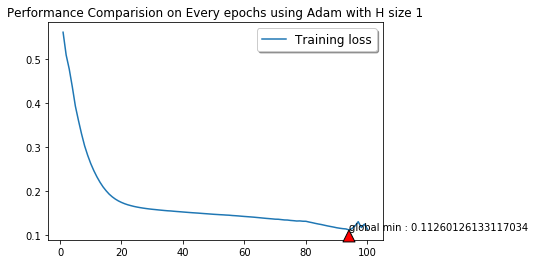

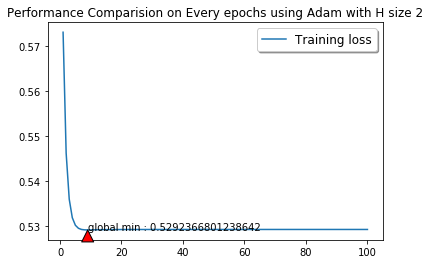

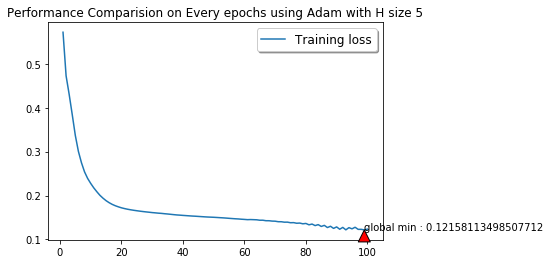

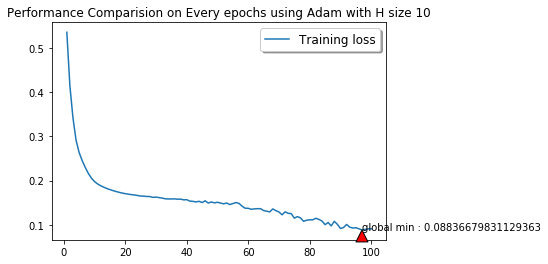

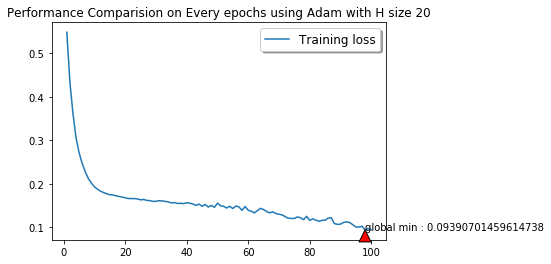

In [26]:
epochs_range = np.arange(1,epochs+1)
for i in range(len(H)):
    #plt.plot(epochs_range,training_loss[i],label="TrainingLoss")
    #plt.plot(epochs_range,testing_loss[i],label="TestingLoss")
    #plt.plot(epochs_range,accuracy[i],label="accuracy")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    line, = ax.plot(epochs_range, training_loss[i],label="Training loss")

    ymax = min(training_loss[i])
    xpos = training_loss[i].index(ymax)
    xmax = epochs_range[xpos]
    name = 'global min : '+ str(ymax)
    ax.annotate(name, xy=(xmax, ymax), xytext=(xmax, ymax),
                arrowprops=dict(facecolor='red', shrink=0.005),
                )
    
    plt.legend(loc='best', shadow=True, fontsize='large')
    title = 'Performance Comparision on Every epochs using Adam with H size '+str(H[i])
    plt.title(title)
    plt.show()

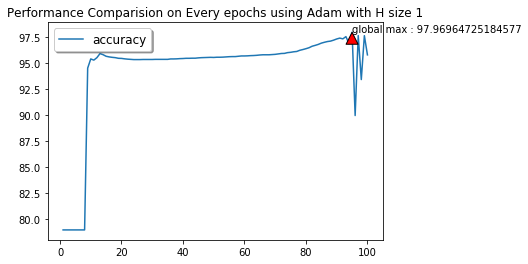

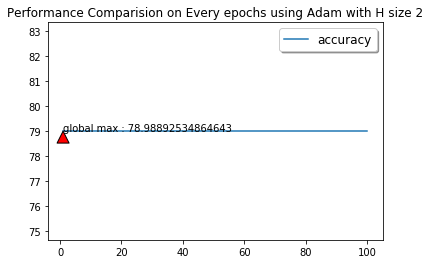

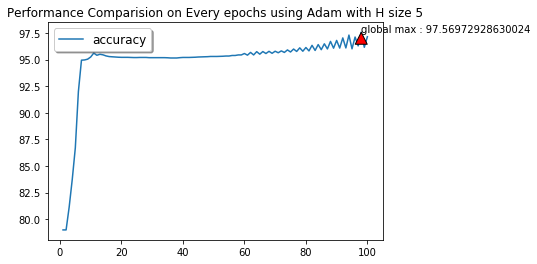

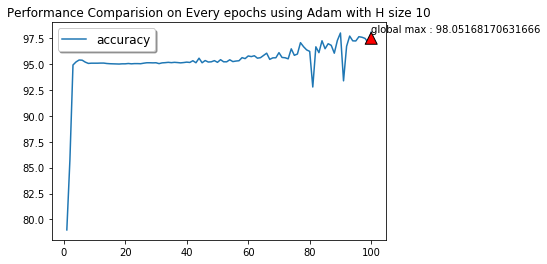

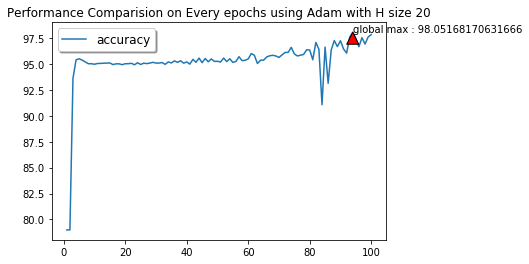

In [27]:
for i in range(len(H)):
    #plt.plot(epochs_range,training_loss[i],label="TrainingLoss")
    #plt.plot(epochs_range,testing_loss[i],label="TestingLoss")
    #plt.plot(epochs_range,accuracy[i],label="accuracy")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    line, = ax.plot(epochs_range, accuracy[i],label="accuracy")

    ymax = max(accuracy[i])
    xpos = accuracy[i].index(ymax)
    xmax = epochs_range[xpos]
    name = 'global max : '+ str(ymax)
    ax.annotate(name, xy=(xmax, ymax), xytext=(xmax, ymax),
                arrowprops=dict(facecolor='red', shrink=0.005),
                )
    plt.legend(loc='best', shadow=True, fontsize='large')
    title = 'Performance Comparision on Every epochs using Adam with H size '+str(H[i])
    plt.title(title)
    plt.show()

# 3 f With MSE

### 3c

In [28]:
train_loader = utils.DataLoader(my_dataset,batch_size=100) # create your dataloader
lr_schedule = [0.1,0.2,0.01,0.02]

loss_schedule = []
training_accuracy_for_lr = []
testing_accuracy_for_lr = []

epochs = 30

for lr in lr_schedule:
    print("\n\nfor lr ",lr)
    model = Net(X_train.shape[1],5)
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    
    train_loader = utils.DataLoader(my_dataset,batch_size=X_train.shape[0]) # create your dataloader

    loss,_,test_acc,train_acc = trainModel(model, train_loader, optimizer, criterion,epochs,X_test,y_test,X_train,y_train,True)
    
    testing_accuracy_for_lr.append(test_acc)
    training_accuracy_for_lr.append(train_acc)
    
    #_,acc = testModel(model,X_test,y_test,epochs)
    
    loss_schedule.append(loss)
    print()



for lr  0.1
Epoch 0: train loss: 0.22668887674808502
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 1: train loss: 0.22452804446220398
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 2: train loss: 0.22243574261665344
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 3: train loss: 0.2204098254442215
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 4: train loss: 0.218448206782341
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 5: train loss: 0.21654890477657318
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 6: train loss: 0.21470996737480164
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Ep

Epoch 28: train loss: 0.16786746680736542
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 29: train loss: 0.16684792935848236
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643




for lr  0.01
Epoch 0: train loss: 0.2640984058380127
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353567

Epoch 1: train loss: 0.2636246085166931
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353567

Epoch 2: train loss: 0.2631531357765198
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353567

Epoch 3: train loss: 0.2626839876174927
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353567

Epoch 4: train loss: 0.2622171640396118
Accuracy of train prediction :  17.72969647251846
Accuracy of Test prediction :  21.011074651353

Epoch 26: train loss: 0.21509279310703278
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 27: train loss: 0.21477457880973816
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 28: train loss: 0.21445873379707336
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643

Epoch 29: train loss: 0.21414519846439362
Accuracy of train prediction :  65.77112387202625
Accuracy of Test prediction :  78.98892534864643




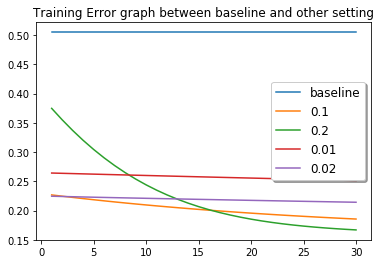

In [30]:
epochs_range = np.arange(1,epochs+1)
baseline = np.ones(epochs)*baseline_loss#random.randint(0,1000,size=(100))
# other = np.random.randint(0,1000,size=(100))
# baseline = np.sort(baseline)
# other = np.sort(other)


plt.plot(epochs_range,baseline,label="baseline")
for i in range(len(loss_schedule)):
    name = str(lr_schedule[i])
    plt.plot(epochs_range,loss_schedule[i],label=name)
plt.legend(loc='best', shadow=True, fontsize='large')
plt.title('Training Error graph between baseline and other setting')
plt.show()

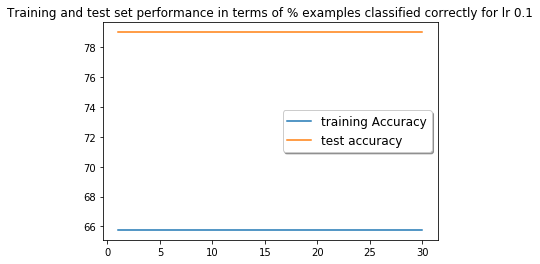

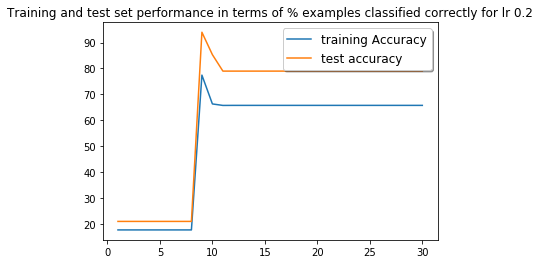

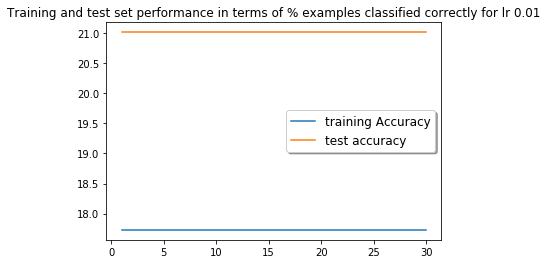

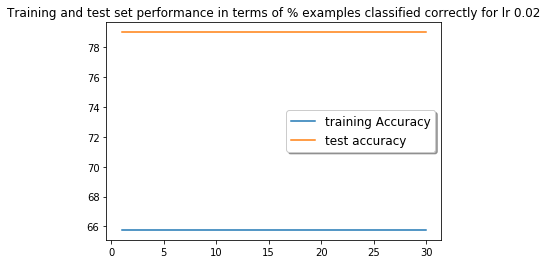

In [31]:
epochs_range = np.arange(1,epochs+1)
for i in range(len(loss_schedule)):
    name = str(lr_schedule[i])
    plt.plot(epochs_range,training_accuracy_for_lr[i],label="training Accuracy")
    plt.plot(epochs_range,testing_accuracy_for_lr[i],label="test accuracy")
    plt.legend(loc='best', shadow=True, fontsize='large')
    title = 'Training and test set performance in terms of % examples classified correctly for lr ' + name
    plt.title(title)
    plt.show()

### 3d

#### SGD

In [34]:
model = Net(X_train.shape[1],200)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 20
train_loader = utils.DataLoader(my_dataset,batch_size=1) # create your dataloader

loss_SGD,_,accuracy= trainModel(model, train_loader, optimizer, criterion,epochs,X_test,y_test,X_train,y_train)
#_,acc = testModel(model,X_test,y_test,epochs)

/home/cs18mtech11033/venv/lib/python3.5/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: train loss: 0.011587269198152847
Accuracy of Test prediction :  94.77030352748154

Epoch 1: train loss: 0.00925182246642034
Accuracy of Test prediction :  95.0369155045119

Epoch 2: train loss: 0.009892552487884862
Accuracy of Test prediction :  94.80106644790813

Epoch 3: train loss: 0.010457081819867708
Accuracy of Test prediction :  94.25758818703855

Epoch 4: train loss: 0.011988036362385539
Accuracy of Test prediction :  93.96021328958163

Epoch 5: train loss: 0.01199611815262889
Accuracy of Test prediction :  93.67309269893356

Epoch 6: train loss: 0.011984561438535634
Accuracy of Test prediction :  93.37571780147663

Epoch 7: train loss: 0.011978158466302407
Accuracy of Test prediction :  93.01681706316653

Epoch 8: train loss: 0.0119761404542901
Accuracy of Test prediction :  92.78096800656276

Epoch 9: train loss: 0.011978276625863453
Accuracy of Test prediction :  92.38105004101723

Epoch 10: train loss: 0.011985412585643724
Accuracy of Test prediction :  92.15545529

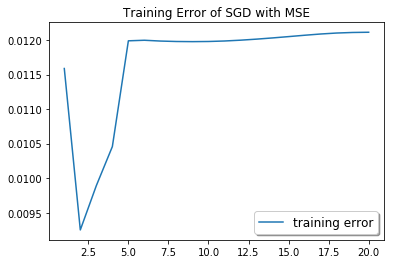

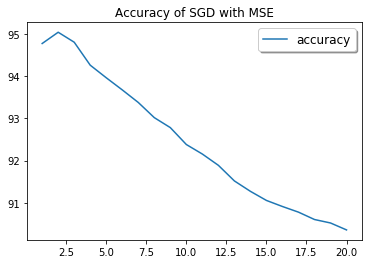

In [35]:
epochs_range = np.arange(1,epochs+1)
plt.plot(epochs_range,loss_SGD,label="training error")

# plt.plot(epochs_range,,label=name)
plt.legend(loc='best', shadow=True, fontsize='large')
plt.title('Training Error of SGD with MSE')
plt.show()

plt.plot(epochs_range,accuracy,label="accuracy")

plt.legend(loc='best', shadow=True, fontsize='large')
plt.title('Accuracy of SGD with MSE')
plt.show()

#### SGD Mini batch size 100

In [32]:
model = Net(X_train.shape[1],200)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 20
train_loader = utils.DataLoader(my_dataset,batch_size=100) # create your dataloader

loss_SGD,_,accuracy= trainModel(model, train_loader, optimizer, criterion,epochs,X_test,y_test,X_train,y_train)
#_,acc = testModel(model,X_test,y_test,epochs)

Epoch 0: train loss: 0.14581512815387146
Accuracy of Test prediction :  78.9991796554553

Epoch 1: train loss: 0.11474475881550461
Accuracy of Test prediction :  86.95652173913044

Epoch 2: train loss: 0.0955325164406265
Accuracy of Test prediction :  94.01148482362592

Epoch 3: train loss: 0.08439394302109665
Accuracy of Test prediction :  94.5036915504512

Epoch 4: train loss: 0.07795235528979769
Accuracy of Test prediction :  94.56521739130434

Epoch 5: train loss: 0.07397149966336877
Accuracy of Test prediction :  94.80106644790813

Epoch 6: train loss: 0.07120631713911368
Accuracy of Test prediction :  95.0369155045119

Epoch 7: train loss: 0.06918014338908705
Accuracy of Test prediction :  95.01640689089417

Epoch 8: train loss: 0.06766546426536856
Accuracy of Test prediction :  94.87284659557014

Epoch 9: train loss: 0.06651753871935909
Accuracy of Test prediction :  94.92411812961444

Epoch 10: train loss: 0.06559783886733363
Accuracy of Test prediction :  94.96513535684987

Ep

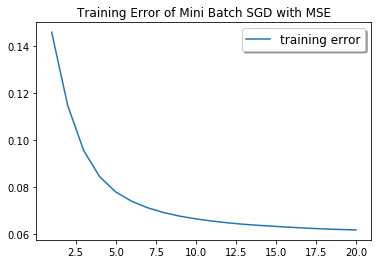

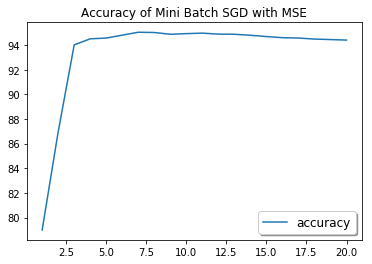

In [33]:
epochs_range = np.arange(1,epochs+1)
plt.plot(epochs_range,loss_SGD,label="training error")

# plt.plot(epochs_range,,label=name)
plt.legend(loc='best', shadow=True, fontsize='large')
plt.title('Training Error of Mini Batch SGD with MSE')
plt.show()

plt.plot(epochs_range,accuracy,label="accuracy")

plt.legend(loc='best', shadow=True, fontsize='large')
plt.title('Accuracy of Mini Batch SGD with MSE')
plt.show()

### 3e

In [36]:
H = [1, 2, 5, 10, 20]
training_loss = []
testing_loss = []
accuracy = []
epochs = 30
for h in H:
    print("For H ",h)
    model = Net(X_train.shape[1],h)
    model = model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    train_loader = utils.DataLoader(my_dataset,batch_size=100) # create your dataloader
    train_loss,test_loss,test_acc = trainModel(model, train_loader, optimizer, criterion,epochs,X_test,y_test,X_train,y_train)
    training_loss.append(train_loss)
    testing_loss.append(test_loss)
    accuracy.append(test_acc)

For H  1
Epoch 0: train loss: 0.22997537400664353
Accuracy of Test prediction :  78.98892534864643

Epoch 1: train loss: 0.1628837530024168
Accuracy of Test prediction :  78.98892534864643

Epoch 2: train loss: 0.1504672706899483
Accuracy of Test prediction :  78.9991796554553

Epoch 3: train loss: 0.13713111221881175
Accuracy of Test prediction :  81.62428219852337

Epoch 4: train loss: 0.12365531061616976
Accuracy of Test prediction :  84.35192780968006

Epoch 5: train loss: 0.1095636290634369
Accuracy of Test prediction :  87.84864643150124

Epoch 6: train loss: 0.09637861627313059
Accuracy of Test prediction :  93.46800656275636

Epoch 7: train loss: 0.08765214832681345
Accuracy of Test prediction :  94.99589827727645

Epoch 8: train loss: 0.08198787396342107
Accuracy of Test prediction :  94.99589827727645

Epoch 9: train loss: 0.07703962392264568
Accuracy of Test prediction :  95.33429040196883

Epoch 10: train loss: 0.07316341647514846
Accuracy of Test prediction :  95.580393765

Epoch 0: train loss: 0.18752624752090835
Accuracy of Test prediction :  78.98892534864643

Epoch 1: train loss: 0.15755999708411897
Accuracy of Test prediction :  78.98892534864643

Epoch 2: train loss: 0.12934175042276522
Accuracy of Test prediction :  78.98892534864643

Epoch 3: train loss: 0.10727878100886123
Accuracy of Test prediction :  78.98892534864643

Epoch 4: train loss: 0.09479228022832015
Accuracy of Test prediction :  94.97538966365873

Epoch 5: train loss: 0.08675646532977159
Accuracy of Test prediction :  95.36505332239541

Epoch 6: train loss: 0.07956364332121887
Accuracy of Test prediction :  95.04716981132076

Epoch 7: train loss: 0.07317303181356159
Accuracy of Test prediction :  94.60623461853979

Epoch 8: train loss: 0.0679134547411572
Accuracy of Test prediction :  94.53445447087776

Epoch 9: train loss: 0.06358507865998701
Accuracy of Test prediction :  94.48318293683347

Epoch 10: train loss: 0.06082349081655748
Accuracy of Test prediction :  94.58572600492207


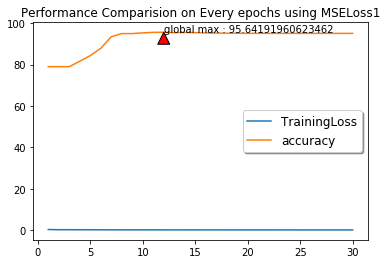

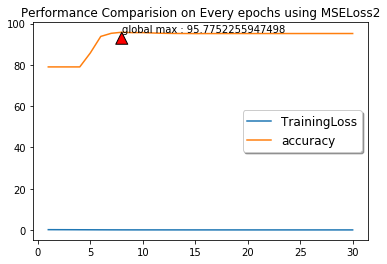

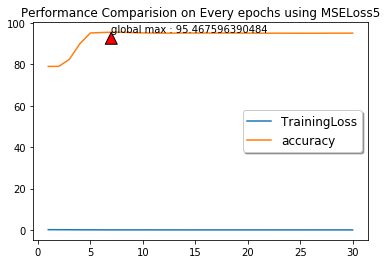

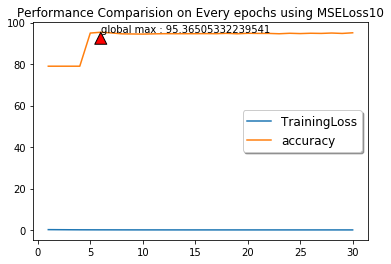

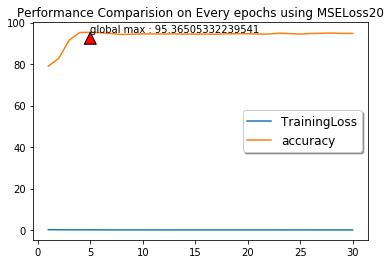

In [37]:
epochs_range = np.arange(1,epochs+1)
for i in range(len(H)):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(epochs_range,training_loss[i],label="TrainingLoss")
    line, = ax.plot(epochs_range, accuracy[i],label="accuracy")

    ymax = max(accuracy[i])
    xpos = accuracy[i].index(ymax)
    xmax = epochs_range[xpos]
    name = 'global max : '+ str(ymax)
    ax.annotate(name, xy=(xmax, ymax), xytext=(xmax, ymax),
                arrowprops=dict(facecolor='red', shrink=0.005),
                )

    # ax.set_ylim(0,20)
    plt.legend(loc='best', shadow=True, fontsize='large')

    title = 'Performance Comparision on Every epochs using MSELoss'+str(H[i])
    plt.title(title)
    plt.show()
#     plt.plot(epochs_range,training_loss[i],label="TrainingLoss")
#     plt.plot(epochs_range,accuracy[i],label="accuracy")
#     plt.legend(loc='best', shadow=True, fontsize='large')
#     title = 'Performance Comparision on Every epochs using Adam with H size '+str(H[i])
#     plt.title(title)
#     plt.show()

### Report
#### In 3c 
There is not of much difference performance as accuracy but MSELoss is better than BCELoss as we are using sigmoid in last layer. 

#### In 3d

###### BCE
Epoch 19: train loss: 0.17501012519109857

Accuracy of Test prediction :  94.30885972108285


###### MSE
Epoch 19: train loss: 0.061820121561695265

Accuracy of Test prediction :  94.40114848236259

#### In 3e
BCELoss performs better than MSE in terms of accuracy.

# 3 g

In [43]:
class Net2layer(torch.nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2):
        super(Net2layer, self).__init__()
        self.input_size = input_size
        self.hidden_size1  = hidden_size1
        self.hidden_size2  = hidden_size2
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size1)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size1, self.hidden_size2)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(self.hidden_size2, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu1(hidden)
        output1 = self.fc2(relu)
        output2 = self.relu2(output1)
        output3 = self.fc3(output2)
        output = self.sigmoid(output3)
        return output

In [44]:
Net2layer(X_train.shape[1],10,5)

Net2layer(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=10, out_features=5, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [45]:
model= Net2layer(X_train.shape[1],20,10)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 30
train_loader = utils.DataLoader(my_dataset,batch_size=100) # create your dataloader
train_loss,_,test_acc = trainModel(model, train_loader, optimizer, criterion,epochs,X_test,y_test,X_train,y_train)

Epoch 0: train loss: 0.5796145577801437
Accuracy of Test prediction :  78.98892534864643

Epoch 1: train loss: 0.47479258695753607
Accuracy of Test prediction :  78.98892534864643

Epoch 2: train loss: 0.40263823133598015
Accuracy of Test prediction :  89.9200164068909

Epoch 3: train loss: 0.4092357751087104
Accuracy of Test prediction :  95.04716981132076

Epoch 4: train loss: 0.2960144472194881
Accuracy of Test prediction :  94.47292863002461

Epoch 5: train loss: 0.24332220282223893
Accuracy of Test prediction :  93.94995898277277

Epoch 6: train loss: 0.22002796337530925
Accuracy of Test prediction :  94.36013125512716

Epoch 7: train loss: 0.20298075378963315
Accuracy of Test prediction :  94.20631665299426

Epoch 8: train loss: 0.19489049562678967
Accuracy of Test prediction :  94.39089417555373

Epoch 9: train loss: 0.18848363604189305
Accuracy of Test prediction :  94.45242001640689

Epoch 10: train loss: 0.1846520807998675
Accuracy of Test prediction :  94.61648892534865

Epo

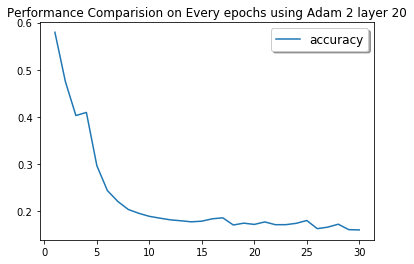

In [46]:
epochs_range = np.arange(1,epochs+1)
plt.plot(epochs_range,train_loss,label="accuracy")

plt.legend(loc='best', shadow=True, fontsize='large')
title = 'Performance Comparision on Every epochs using Adam 2 layer '+str(H[i])
plt.title(title)
plt.show()


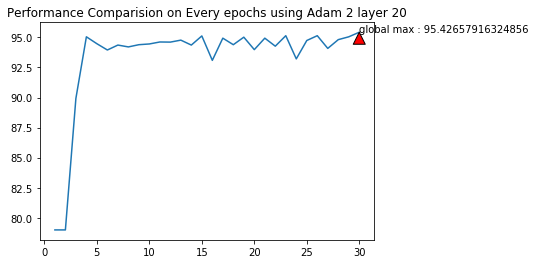

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)

line, = ax.plot(epochs_range, test_acc,label="accuracy")

ymax = max(test_acc)
xpos = test_acc.index(ymax)
xmax = epochs_range[xpos]
name = 'global max : '+ str(ymax)
ax.annotate(name, xy=(xmax, ymax), xytext=(xmax, ymax),
            arrowprops=dict(facecolor='red', shrink=0.005),
            )

# ax.set_ylim(0,20)
title = 'Performance Comparision on Every epochs using Adam 2 layer '+str(H[i])
plt.title(title)
plt.show()

### With h1-100 h2 - 20
For 30 Epoch : train loss: 0.1623292575213573

Accuracy of Test prediction :  93.65258408531584

### With h1-20 h2 - 10
For 30 Epoch : train loss: 0.1596449170279512

Accuracy of Test prediction :  95.42657916324856

Despite having some variation tried it is not able to outperforms the 3e setting with BCELoss